# Sampling from a DPP

by <a href="http://rbardenet.github.io"> Rémi Bardenet</a> & <a href="http://pierrechainais.ec-lille.fr"> Pierre Chainais</a>, October 2015.

#### General instructions to follow this practical
1. This page is _interactive_: you can execute a cell and move to the next one by typing __Shift + Enter__.
2. You will be able to __change parameter values and execute code cells__ as many times as you wish.
3. __Feel free to play with the notebook__, you won't break anything!
4. At any point, you can reinitialize your environment by clicking the revolving arrow (top right icon) and selecting : __Clear all outputs & Restart__.
5. If you want to execute all cells, click __"Cell" > "Run All"__
6. To scale the font size up for math expressions, right-click on an expression > __"Math settings" > "Scale all"__
6. Be patient: while a cell is being executed, __a small [\*] shows up on the left__.

#### References
We will refer to the following papers here and there.

[LaMoRu] Lavancier F., Møller J., Rubak E. [_Determinantal point process models and statistical inference_](http://arxiv.org/pdf/1205.4818v5). Journal of the Royal Statistical Society, series B, 77(4):853-877, 2015.

[HKPV06] Hough J.B., Krishnapur M., Peres Y., and Virág B. [_Determinantal Processes and Independence_](http://arxiv.org/pdf/math/0503110v2). Probability Surveys, 3:206-229, 2006. 


## The big picture
Remember a DPP is defined by a base measure $\mu$ and a kernel $K$. In this practical, we implement the sampling algorithm in [HKPV06], which starts with a spectral decomposition of the operator $\mathcal{K}$ with kernel $K$ in $L^2(\mu)$, assumed to be trace-class. Formally, 
$$ K({\bf x},{\bf y}) = \sum_i \lambda_i \phi_i({\bf x}) \overline{\phi_i}({\bf y}) $$
where $(\phi_i)$ is an orthonormal sequence of $L^2(\mu)$,
and $\sum \lambda_i < \infty$.
- The first step of the algorithm is to generate a sequence $(B_i)$ of independent Bernoullis with respective parameters $\lambda_i$. The operator being assumed trace-class, Borel-Cantelli guarantees that the number $N$ of ones in this sequence of Bernoullis is a.s. finite.
- Now we build the projection kernel
$$ \tilde{K}({\bf x},{\bf y}) = \sum_i B_i \phi_i({\bf x}) \overline{\phi_i}({\bf y}) $$
and, for $i=0,...,N-1$, we sequentially draw $x_{i+1}$ from the following conditional distribution
$$
x_{i+1} \sim \frac{1}{N-i} \left\{ \tilde{K}({\bf x},{\bf x}) - \overline{{\bf k}^T\tilde{\bf K}^{-1}_i} {{\bf k}}\right\} w({\bf x})d{\bf x},
$$
where $w$ is the pdf of $\mu$ w.r.t. some dominating measure $d{\bf x}$, 
$$
{\bf k} = \begin{pmatrix} k({\bf x},{\bf x_1}) \dots k({\bf x},{\bf x_i})\end{pmatrix}^T
$$
and
$$
\tilde{\bf K}_i = ((\;\tilde{K}({\bf x_u},{\bf x_v})\;))_{1\leq u,v\leq i}
$$

_All along the practical, we'll ask some questions, to underline important facts. Feel free to take notes in the notebook, it's your copy._

__Question:__ How would you describe the distribution of the number of points $N$ in a realization? How does the sequence $(\lambda_i)$ related to the mean and variance of $N$?

__Answer:__ ...

## Setting up the notebook
Let us prepare our working environment by telling python what we need. __Just run the next cell.__

In [1]:
# Make sure figures appear in the notebook and not in a separate window, and that libraries are 
#properly reloaded when changed
%pylab inline
%load_ext autoreload
%autoreload 2

from tools import * # import generic tools, libraries (numpy, ...) and functions (rejection sampling, ...)
from dpp import * # import our homemade DPP library

# Make wide figures
figsize(18,6)

Populating the interactive namespace from numpy and matplotlib


## A first demo
Let's give it a first try: run the following cell to generate a realization of a DPP in $\mathbb{R}^2$. The rest of this practical will be about what is under the hood in the following cell.

>> Initialized DPP
>> Sampled Bernoullis, number of ones is N= 14
Sampling the 14 th point
Sampling the 12 th point
Saving the first conditional
Sampling the 10 th point
Sampling the 8 th point
Sampling the 6 th point
Sampling the 4 th point
Sampling the 2 th point
Sampling the 0 th point
Saving the last conditional
>> Done


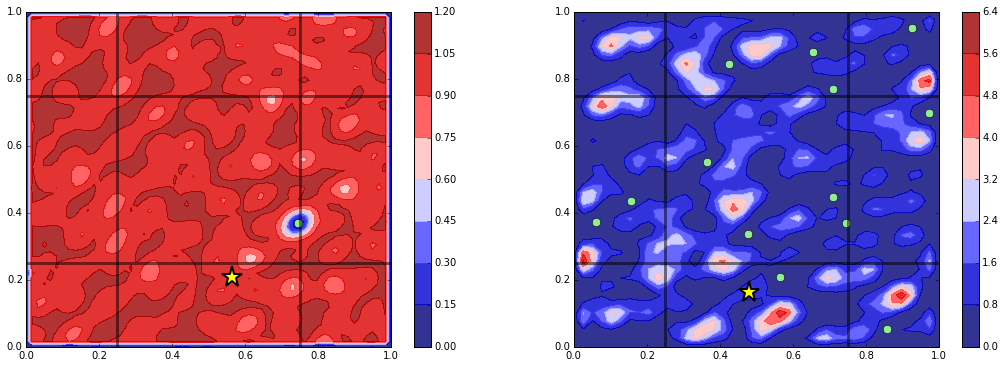

In [10]:
npr.seed(2)            # define the initial seed for random variable simulation
dpp = DPP("Gaussian", trunc=10, params=[20.,.05])  # GENERATE a DPP realization
dpp.checkParams()      # checks whether parameters define an acceptable DPP kernel
dpp.sampleBernoullis() # sample Bernoulli variables weighted by eigen values
dpp.sample()           # sample points successively
dpp.plotConditionals() # illustration : show the 1st and last conditional density distribution

__Questions:__ Play with various sets of values of `params` $= [\rho,\alpha]$ and observe.
1. Can you choose any values? What happens when $\rho$ is too big ?
2. What do you think are the last two plots?
2. Observe how the realizations qualitatively depend on $\rho$ and $\alpha$. 

__Answers:__ ...

## The kernel
We consider here __a Gaussian kernel__ on $\mathbb{R^2}\times\mathbb{R}^2$:
$$
K(x,y) = \rho\exp\left(-\frac{\Vert x-y\Vert^2}{\alpha^2}\right)
$$
with parameters `params` $= [\rho,\alpha]$.
The base measure is uniform on $(0,1)\times(0,1)$ with density $w=1$ on the unit square.

__Questions:__
1. What is the expected number $\mathbb{E}[N]$ of points in a realization of this DPP?
2. How does it depend on the size of the domain ?

__Answers:__
...



The following `DPP` object allows you to define a DPP on $\mathbb{R^2}$ with Gaussian kernel and uniform base measure, with parameters `params` $= [\rho,\alpha]$. Once the DPP defined, you can __evaluate the corresponding kernel__ $K(x,y)$ for any pair of points $x$ and $y$ as follows:

In [3]:
dpp = DPP("Gaussian", params=[11.,.05])
x = npr.rand(2)   # random x
y = npr.rand(2)   # random y
print x, y, dpp.kernel(x,y)   # evaluate K(x,y)

>> Initialized DPP
[ 0.89042419  0.24942684] [ 0.22886458  0.43461847] 1.13254628181e-81


## Approximating the eigendecomposition of the kernel
Remember from the big picture above that we need an eigendecomposition of operator $\mathcal{K}$ to sample the corresponding DPP. Following [LaMoRu12], we approximate stationary kernels by approximating their Fourier series. More precisely, if $K$ is stationary, then $K(x,y) = K_0(x-y)$ for some $K_0$. We let $S = [-1/2,1/2]^d$ and $\beta S=[-\beta/2,\beta/2]$. If $x,y\in S/2$, then $x-y\in S$. Denoting by $\Phi_k(u) = \exp(2i\pi k\cdot u)$ the Fourier basis of $L^2(S)$, the Fourier series of $K_0$ is

$$
K_0(\mathbf{u}) = \sum_{\mathbf{k}\in\mathbb{Z}^d} c_\mathbf{k} \Phi_\mathbf{k}(\mathbf{u}), \quad \mathbf{u}\in S,
$$
where
$$
c_\mathbf{k} = \int_S K_0(\mathbf{x}) e^{-2i\pi \mathbf{k}\cdot \mathbf{x}} d\mathbf{x}. 
$$
Extending this to $\mathbf{x},\mathbf{y}\in S$, we approximate $K$ on $S$ by the "periodic" kernel

$$
K^{\text{per}}(\mathbf{x},\mathbf{y}) = \sum_{\mathbf{k}\in\mathbb{Z}^d} c_\mathbf{k} \Phi_\mathbf{k}(\mathbf{x},\mathbf{y}),\quad \mathbf{x},\mathbf{y}\in S.
$$
In common stationary models (Gaussian, Matern, ...), we don't know how to compute the $c_\mathbf{k}$s, but we know the Fourier transform $\varphi$ of $K_0$, aka the spectral density of the kernel. For the Gaussian kernel, for example, the spectral density reads [LaMoRu12]

$$
\varphi(\mathbf{k}) = \int K_0(\mathbf{x})e^{-2i\pi \mathbf{k}\cdot \mathbf{x}}d\mathbf{x} = \rho(\sqrt{\pi}\alpha)^d\exp(-\Vert \pi \alpha \mathbf{k}\Vert^2).
$$

If $K_0$ is not too large outside $S$, we expect $\varphi(\mathbf{k})$ to be a good approximation to $c_\mathbf{k}$. On top of this, we truncate the Fourier decompositions to 

$$ Z_K = \{\mathbf{z} \in \mathbb{Z}^d: \Vert \mathbf{z}\Vert_0 \leq K\}$$

to make sure we know when to stop sampling Bernoullis. This leads to [LaMoRu12]'s final approximation

$$
K^{\text{per}}_{\text{app}}(x,y) = \sum_{\mathbf{k}\in Z_K\subset\mathbb{Z}^d} \varphi(\mathbf{k}) \Phi_\mathbf{k}(\mathbf{x})\overline{\Phi_\mathbf{k}(\mathbf{y})} = \sum_{\mathbf{k}\in Z_K\subset\mathbb{Z}^d} \varphi(\mathbf{k})\Phi_\mathbf{k}(\mathbf{x}-\mathbf{y}), \quad \mathbf{x},\mathbf{y}\in S.
$$

Note that in real life, your kernel may not require all these steps, these are simply an example of how to obtain a suitable decomposition for stationary kernels. 

Here is how to evaluate the kernel $K_{\text{app}}^{\text{per}}(x,y)$ in practice.

In [4]:
dpp = DPP("Gaussian", trunc=10, params=[20.,.1])
dpp.checkParams()
x = npr.rand(2)
y = npr.rand(2)
print x, y, dpp.kernel(x,y), dpp.kernel_per_app(x,y)

>> Initialized DPP
[ 0.59927783  0.5720488 ] [ 0.53047123  0.76703791] 0.278099072705 0.278083172142


The parameter `trunc` controls the truncation level $K$ of the Fourier series, i.e. the number of eigenfunctions that is used. You can check that our approximation of the kernel gets better as `trunc` increases. For this, we now compare kernels $K$ and $K_{\text{app}}^{\text{per}}$ graphically. We plot the kernel evaluated at $(0,x)$ for $x\in [0,1]^2$ for both kernels. 

*__Remark :__ Note the white square $Q=[1/4,3/4]^2$ that we highlight.  This is where the Fourier approximation is supposed to be good. Using the Fourier approximation outside $Q$ is the extension step we made above by defining $K^\text{per}$. If you don't mind having a bad approximation outside the square or don't want a headache, you can skip the rest of this paragraph. For points $x,y\in Q$, we can expect $K^\text{per}(x,y)\approx K(x,y)$. When $x$ and $y$ are further apart, the approximation deteriorates, so that correlations of a range larger than $1/2$ will not be well approximated. [LaMoRu12] thus start by saying that the safest thing is to run the sampling algorithm on the DPP $X^{\text{per}}_{\text{app}}$ with kernel $K^{\text{per}}_{\text{app}}$ and base density $w=1_{[0,1]^d}$, obtain a realization and keep only points in $Q$, which are a good approximation to samples from $X\cap Q$, where $X$ corresponds to the ideal DPP with Gaussian kernel and uniform base measure on the unit square: this is called the _border method_ in [LaMoRu12]. To obtain good approximate samples of $X$, they recommend applying the border method to $T(X)$ where $T$ is the affine transformation that maps $[0,1]^d$ onto $Q$. The kernel for this new DPP is analytically known and applying the inverse of $T$ to the selected samples in $Q$ yields a good approximate sample of $X$. However, [LaMoRu12] then remark that actually, realizations of $X^{\text{per}}_{\text{app}}$ are also good approximations for realizations of $X$. If you don't see why, wait until you see conditional DPP densities below. For simplicity, we follow the latter path here.* 

>> Initialized DPP


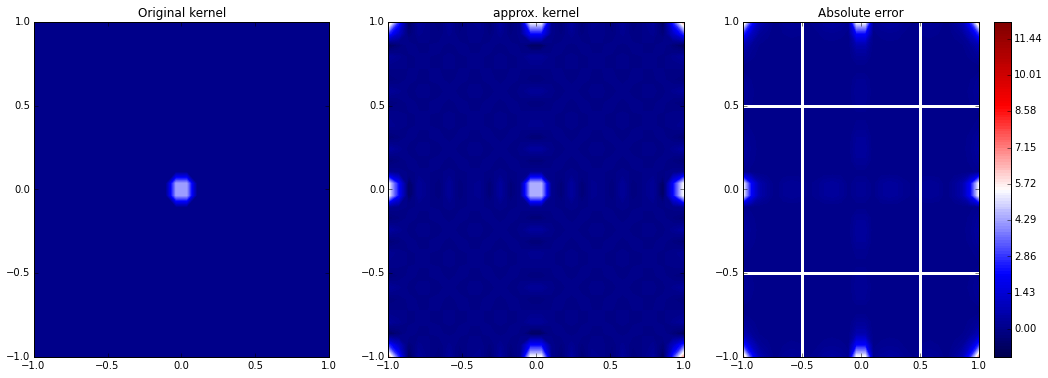

In [5]:
dpp = DPP("Gaussian", trunc=5, params=[11.,.05])
dpp.checkParams()
dpp.compareKernels()

__Question:__ In the previous cell, try different values of `trunc` (positive integer) and observe the quality of the resulting approximation on the graphics. When does it fail to be a good approximation?

__Comments:__ ...

## Simulating a DPP

Almost there! Now we go back to the full sampling procedure and explain the last bits.

>> Initialized DPP
>> Sampled Bernoullis, number of ones is N= 20
Sampling the 20 th point
Saving the first conditional
Sampling the 16 th point
Sampling the 12 th point
Sampling the 8 th point
Sampling the 4 th point
Sampling the 0 th point
Saving the last conditional
>> Done


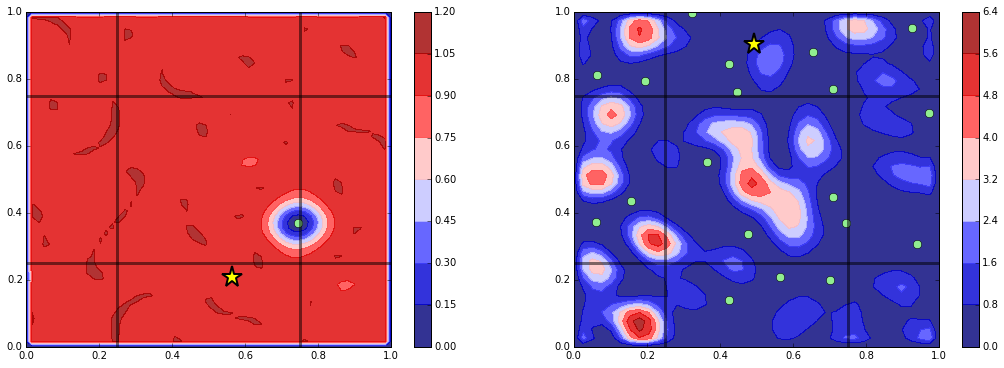

In [6]:
npr.seed(2)            # define the initial seed for random variable simulation
dpp = DPP("Gaussian", trunc=10, params=[20.,.1])  # Initialize a DPP instance
dpp.checkParams()      # check whether parameters define an acceptable DPP kernel
dpp.sampleBernoullis() # sample Bernoulli variables with parameters the kernel eigenvalues
dpp.sample()           # sample points successively
dpp.plotConditionals() # illustration: show the 1st and last conditional densities

You may observe that points tend to appear far from each other. The shape of the kernel controls the "interaction potential" between "particles". To show this, one can represent the conditional densities during the sampling procedure. The latter two plots are the density of the second point given the realization of the first, and the __density of the last point knowing all previous ones__. Of course, terms as "first" and "last" only make sense for the sampling procedure, the final point process realization is unordered.

__Let's have a closer look at how the sampling is done, and how to plot these conditional densities__. Remember the big picture? We have a realization of the random kernel
$$
\tilde{K}_{\text{per}}^{\text{app}} = \sum_{i\in I} B_i \phi_i({\bf x}) \overline{\phi_i({\bf y})}.
$$
Points are now iteratively generated, taking into account all points in the DPP realization that have already been sampled. 

The first point of the DPP realization is sampled from the intensity measure
$$ \frac{1}{N} \tilde{K}_{\text{per}}^{\text{app}}({\bf x},{\bf x}) w({\bf x})d{\bf x}.$$
To this end we use rejection sampling. If you have time, you can check what rejection sampling is in the companion notebook _testTools.ipynb_.  The code below does exactly this and then represents the corresponding density. Change the parameter of `npr.seed` to observe different realizations.

>> Initialized DPP
>> Sampled Bernoullis, number of ones is N= 20


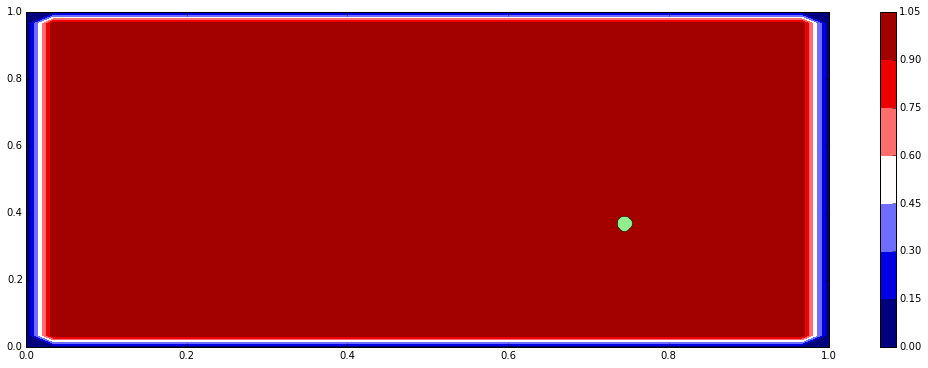

In [7]:
npr.seed(2)            # define the initial seem for random variable simulation
dpp = DPP("Gaussian", trunc=10, params=[20.,.1])  # Initialize a DPP instance
dpp.checkParams()
dpp.sampleBernoullis() # N is then defined to be the number of ones
f1 = lambda x: realify(dpp.KTilde(x,x)*dpp.w(x)/dpp.N) # this is the intensity measure, this is a function f(x)
x1, success = rejectionSamplingWithUniformProposal(f1, Z=1., d=2) # Z=1. is an upper bound on f1, 2 is the dimension

# let us plot the contours of density f1
xPlot = np.linspace(0,1,30)
ZPlot = np.array([[f1(np.array([xi, xj])) for xj in xPlot] for xi in xPlot])
plt.contourf(xPlot, xPlot, ZPlot, cmap="seismic")
plt.colorbar()
# and let us add the realization x1 on the plot
plt.plot(x1[0], x1[1], 'o', color='lightgreen', markersize=15)
plt.show()

Now let us generate the 2nd point of this DPP realization. As explained in the big picture, for $i=1,...,N$, we sequentially draw $x_i$ from the following conditional pdf

$$
{\bf x}_i \sim \frac{1}{N-i+1} \left\{ \tilde{K}({\bf x},{\bf x}) - \overline{{\bf k}^T\tilde{\bf K}^{-1}_i} {{\bf k}}\right\} w({\bf x})d{\bf x},
$$
where $w$ is the pdf of $\mu$ w.r.t. some dominating measure $d{\bf x}$, here the Lebesgue measure, 
$$
{\bf k} = \begin{pmatrix} k({\bf x},{\bf x}_1) \dots k(x,x_i)\end{pmatrix}^T,
$$
and
$$
\tilde{\bf K}_i = ((\;\tilde{K}({\bf x}_u,{\bf x}_v)\;))_{1\leq u,v\leq i}.
$$

Now we generate a second point ${\bf x}_2$ knowing ${\bf x}_1$ from the appropriate conditional (see Section "The big picture"):

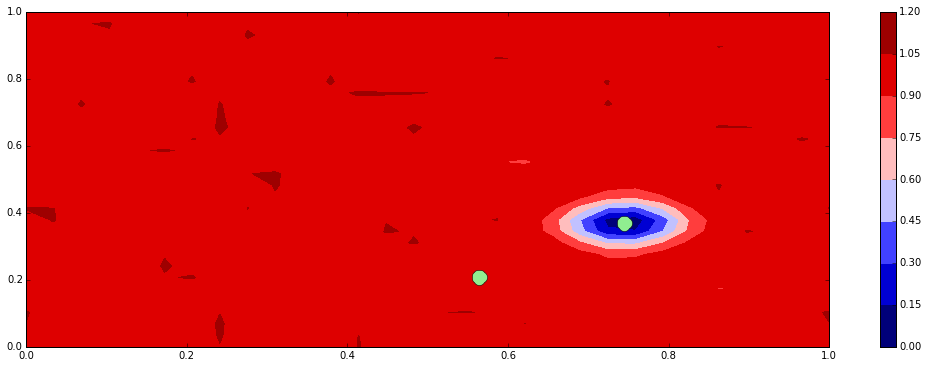

In [8]:
j = 2   # index of current point
N = dpp.N
# Definition of the distribution f(x_2|x_1)
f2 = lambda x: 1.0/(N-1)* realify( dpp.KTilde(x,x) - \
                                     dpp.KTilde(x1,x)*dpp.KTilde(x,x1)/np.conjugate(dpp.KTilde(x1,x1)))
# Rejection sampling according to f2
x2, success = rejectionSamplingWithUniformProposal(f2, Z=N*1./(N-j+1), d=2) # 1. is an upper bound on f, 2 is the dimension

## Graphical illustrations
# Let us plot the contours of f2
xPlot = np.linspace(0,1,30)
ZPlot = np.array([[f2(np.array([xi, xj])) for xi in xPlot] for xj in xPlot])
plt.contourf(xPlot, xPlot, ZPlot, cmap="seismic")
plt.colorbar()

# And we add x1 and x2 
plt.plot([x1[0], x2[0]], [x1[1], x2[1]], 'o', markersize=15, color="lightgreen")

__Last question (well done!):__ Iterate the last cell and write the full sampling loop to obtain the `dpp.N` points of the realization. 

__Bonus question (man, you're quick, we'll slow you down with that one):__ Open our homemade `dpp.py` in a text editor, and add another kernel to the class. Say the Matern kernel, for which the spectral density is given in [LaMoRu12]. What differences do you observe with the Gaussian kernel? 

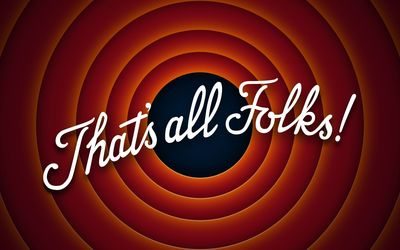

In [9]:
from IPython.display import Image
Image(filename='Thats-all-folks.jpg')